# Práctica 1 - Red Neuronal

### Utilidades

#### Configuración del dispositivo de cómputo
Selecciona automáticamente GPU si está disponible, o CPU en caso contrario, e imprime el dispositivo usado para entrenar la red.

In [29]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando dispositivo:", DEVICE)

Usando dispositivo: cuda


#### Fijación de semilla para reproducibilidad
La siguiente función, `seed_everything`, asegura que los experimentos sean reproducibles fijando la semilla para PyTorch, CUDA, NumPy y el generador de números aleatorios de Python. También configura CUDA para un comportamiento determinista cuando se usa GPU.

In [30]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Preparación de datasets y dataloaders
La función `prepare_dataloaders` utiliza TensorFlow/Keras para cargar imágenes desde un directorio (dataset_path), dividiéndolas en conjuntos de entrenamiento, validación y prueba basándose en la estructura de subdirectorios (train, val y test). 

Aplica un preprocesamiento básico a las imágenes, como redimensionarlas a $48 \times 48$ píxeles, convertirlas a escala de grises (o el modo de color especificado), y las organiza en lotes (batch_size=64). 

Además, utiliza la codificación one-hot (label_mode='categorical') para las etiquetas, mezcla el conjunto de entrenamiento (shuffle=True) para asegurar la aleatoriedad, y aplica optimizaciones de carga de datos (cache().prefetch()) para mejorar la velocidad del entrenamiento.

In [31]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def prepare_dataloaders(dataset_path: str,
                        batch_size=64,
                        img_size=(48, 48),
                        color_mode='grayscale'):
    
    # Definir transformaciones
    # ToTensor convierte [0, 255] a [0.0, 1.0] automáticamente
    if color_mode == 'grayscale':
        transform_list = [
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    else:
        transform_list = [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
        
    data_transform = transforms.Compose(transform_list)

    train_dir = os.path.join(dataset_path, 'train')
    val_dir = os.path.join(dataset_path, 'val') 
    test_dir = os.path.join(dataset_path, 'test')

    # Cargar Datasets
    train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)

    # Dataloaders
    # num_workers > 0 paraleliza la carga (similar a prefetch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, train_dataset.classes

#### Gráfico de las curvas de accuracy durante el entrenamiento y la validación de la red neuronal.
A continuación, se definirá una función que muestre cómo cambian la pérdida (loss) y la precisión (accuracy) del modelo en entrenamiento y validación a lo largo de las épocas. Esto permite evaluar el aprendizaje de la red, detectar overfitting o underfitting, y comparar el desempeño entre diferentes configuraciones del modelo.

La precisión se calcula como:
$$
\text{Accuracy} = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}} \times 100\%
$$

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    if history is None: return
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.get('train_loss', []), label='Train Loss')
    plt.plot(history.get('val_loss', []), label='Val Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    # Ajuste: En PyTorch guardamos 0-1, en gráfico queremos 0-100 si comparamos con Keras
    # O simplemente graficamos lo que hay.
    train_acc_plot = [x * 100 if x <= 1 else x for x in history.get('train_acc', [])]
    val_acc_plot = [x * 100 if x <= 1 else x for x in history.get('val_acc', [])]
    
    plt.plot(train_acc_plot, label='Train Acc')
    plt.plot(val_acc_plot, label='Val Acc')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

#### Matriz de confusión
Asimismo, la siguiente función muestra la comparación entre las etiquetas reales (`y_true`) y las predicciones del modelo (`y_pred`) para cada clase. Permite identificar qué clases se confunden entre sí y evaluar detalladamente el desempeño del modelo en clasificación.

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    if y_true is None or y_pred is None: return
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('Etiqueta Real'); plt.xlabel('Etiqueta Predicha')
    plt.tight_layout(); plt.show()

#### Guardar campos en el CSV

In [34]:
import json
import pandas as pd
import os

def save_results(all_results):
    if not all_results: 
        return
    
    df_results = pd.DataFrame(all_results)
    df_results["history_dict"] = df_results["history_dict"].apply(json.dumps)
    df_results["y_true"] = df_results["y_true"].apply(lambda x: json.dumps(x.tolist()))
    df_results["y_pred"] = df_results["y_pred"].apply(lambda x: json.dumps(x.tolist()))

    # Cada experimento como columna
    df_csv = df_results.T
    csv_filename = "resultados_cnn_fer2.csv"

    def decimal_to_comma(df):
        return df.applymap(lambda x: str(x).replace('.', ',') if isinstance(x, (float, int)) else x)

    if not os.path.exists(csv_filename):
        df_to_save = decimal_to_comma(df_csv)
        df_to_save.to_csv(csv_filename, sep=';', index=True)

    else:
        # Cargar CSV anterior
        df_prev = pd.read_csv(csv_filename, sep=';', index_col=0)

        # Preparar nuevo bloque
        df_new = decimal_to_comma(df_csv)

        # Asegurar que los índices coincidan
        df_prev, df_new = df_prev.align(df_new, join='outer')

        # Concatenar como columnas
        df_combined = pd.concat([df_prev, df_new], axis=1)

        df_combined.to_csv(csv_filename, sep=';', index=True)

    print(f"Resultados guardados en: {csv_filename}\n")


#### Leer desde el CSV

In [35]:
import ast

def robust_json_load(x):
    """
    Intenta cargar JSON de forma estricta. Si falla, intenta corregir
    formatos comunes (comillas simples, booleanos de Python, etc.)
    usando ast.literal_eval.
    """
    if not isinstance(x, str):
        return x
    try:
        return json.loads(x)
    except (json.JSONDecodeError, TypeError):
        try:
            # Reemplazos para hacer compatible string formato Python con JSON/eval
            x_fixed = x.replace("null", "None").replace("true", "True").replace("false", "False")
            return ast.literal_eval(x_fixed)
        except Exception as e:
            print(f"Error decodificando: {e}")
            return None

def load_all_experiments_from_csv(csv_filename):
    # 1. Leer con el separador correcto (punto y coma según tu archivo)
    df = pd.read_csv(csv_filename, sep=';', index_col=0)
    
    # 2. Transponer (Filas = Experimentos)
    df = df.T
    
    # 3. Convertir columnas JSON de forma robusta
    json_cols = ["history_dict", "y_true", "y_pred"]
    for col in json_cols:
        if col in df.columns:
            df[col] = df[col].apply(robust_json_load)
            
    # 4. Convertir test_acc a float manejando la coma decimal
    if "test_acc" in df.columns:
        # Reemplaza ',' por '.' y convierte a float
        df["test_acc"] = df["test_acc"].astype(str).str.replace(',', '.').astype(float)
        
    return df

#### Analizar mejor y peor experimento

In [36]:
def analyze_from_csv(csv_filename, classes):
    df = pd.read_csv(csv_filename, sep=';', index_col=0).T
    json_cols = ["history_dict", "y_true", "y_pred"]
    for col in json_cols:
        if col in df.columns: df[col] = df[col].apply(robust_json_load)
    if "test_acc" in df.columns:
        df["test_acc"] = df["test_acc"].astype(str).str.replace(',', '.').astype(float)

    best = df.loc[df["test_acc"].idxmax()]
    worst = df.loc[df["test_acc"].idxmin()]

    print(f"🏆 Mejor: {best['name']} - {best['test_acc']}%")
    print(f"📉 Peor: {worst['name']} - {worst['test_acc']}%")

    plot_training_history(best["history_dict"], f"Mejor ({best['name']})")
    plot_confusion_matrix(best["y_true"], best["y_pred"], classes, f"Confusion ({best['name']})")

### Entrenamiento CNN desde cero

#### Modelo

In [37]:
import torch.nn as nn

class ModularCNN(nn.Module):
    def __init__(self, input_shape, conv_layers, fc_layers, num_classes, dropout_conv=0.3, dropout_fc=0.4):
        super(ModularCNN, self).__init__()
        
        self.features = nn.Sequential()
        in_channels = input_shape[2]
        
        # --- BLOQUES CONVOLUCIONALES ---
        for i, (out_channels, k, reps) in enumerate(conv_layers):
            for _ in range(reps):
                self.features.add_module(f"conv_{i}_{_}", nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=k//2))
                self.features.add_module(f"relu_{i}_{_}", nn.LeakyReLU(0.1))
                in_channels = out_channels
            
            self.features.add_module(f"pool_{i}", nn.MaxPool2d(2, 2))
            self.features.add_module(f"drop_{i}", nn.Dropout(dropout_conv))

        # --- CAPAS DENSAS ---
        self._to_linear = None
        dummy_input = torch.zeros(1, input_shape[2], input_shape[0], input_shape[1])
        dummy_out = self.features(dummy_input)
        self.flat_dim = int(np.prod(dummy_out.size()))
        
        self.classifier = nn.Sequential()
        in_features = self.flat_dim
        
        for i, units in enumerate(fc_layers):
            self.classifier.add_module(f"fc_{i}", nn.Linear(in_features, units))
            self.classifier.add_module(f"relu_fc_{i}", nn.LeakyReLU(0.1))
            self.classifier.add_module(f"drop_fc_{i}", nn.Dropout(dropout_fc))
            in_features = units
            
        # Capa final (Sin Softmax, CrossEntropyLoss lo aplica internamente)
        self.classifier.add_module("fc_out", nn.Linear(in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

#### Entrenar modelo

`train_one_epoch`: Entrena el modelo durante una época completa: hace forward, calcula la pérdida, realiza backpropagation y actualiza los pesos. Devuelve la pérdida y precisión de entrenamiento.

`validate`: Evalúa el modelo en el conjunto de validación sin actualizar pesos. Se usa para comprobar el rendimiento durante el entrenamiento. Devuelve la pérdida y precisión de validación.

In [38]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / total, correct / total

In [39]:
class EarlyStopping:
    def __init__(self, patience=8, mode='max', verbose=False):
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        score = current_score if self.mode == 'max' else -current_score

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_weights(self, model):
        if self.best_model_state:
            model.load_state_dict(self.best_model_state)

`train_experiment`: Coordina el entrenamiento completo durante varias épocas: llama a train_one_epoch, luego a validate, almacena las métricas y aplica early stopping si el modelo deja de mejorar.

`evaluate_model`: Evalúa el modelo final en el conjunto de test, calculando pérdida, precisión y recopilando todas las predicciones y etiquetas reales para análisis posterior.

In [40]:
import torch.optim as optim

def train_experiment(model, train_loader, val_loader, epochs, lr, patience):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    es = EarlyStopping(patience=patience, mode='max', verbose=True)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        v_loss, v_acc = validate(model, val_loader, criterion)
        
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {t_loss:.4f} - Acc: {t_acc:.4f} - Val Loss: {v_loss:.4f} - Val Acc: {v_acc:.4f}")
        
        es(v_acc, model)
        if es.early_stop:
            print("Early stopping triggered")
            break
            
    es.load_best_weights(model)
    return history

#### Evaluar modelo

In [41]:
def evaluate_model(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    total = len(all_labels)
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / total * 100
    avg_loss = running_loss / total
    
    return acc, avg_loss, np.array(all_labels), np.array(all_preds)

#### Entrenamientos 

Descargando dataset (FER-2013)...

Entrenando experimento: CNN_VGG_Deep_Best

Epoch 1/40 - Loss: 1.5690 - Acc: 0.3021 - Val Loss: 1.5371 - Val Acc: 0.3244
Epoch 2/40 - Loss: 1.4687 - Acc: 0.3639 - Val Loss: 1.3122 - Val Acc: 0.4496
Epoch 3/40 - Loss: 1.2850 - Acc: 0.4771 - Val Loss: 1.1826 - Val Acc: 0.5153
Epoch 4/40 - Loss: 1.1819 - Acc: 0.5196 - Val Loss: 1.0975 - Val Acc: 0.5595
Epoch 5/40 - Loss: 1.0910 - Acc: 0.5647 - Val Loss: 1.0298 - Val Acc: 0.5855
Epoch 6/40 - Loss: 1.0258 - Acc: 0.5921 - Val Loss: 0.9967 - Val Acc: 0.6067
Epoch 7/40 - Loss: 0.9773 - Acc: 0.6132 - Val Loss: 0.9497 - Val Acc: 0.6231
Epoch 8/40 - Loss: 0.9230 - Acc: 0.6401 - Val Loss: 0.9136 - Val Acc: 0.6439
Epoch 9/40 - Loss: 0.8773 - Acc: 0.6624 - Val Loss: 0.8921 - Val Acc: 0.6474
Epoch 10/40 - Loss: 0.8342 - Acc: 0.6798 - Val Loss: 0.8940 - Val Acc: 0.6579
Epoch 11/40 - Loss: 0.7906 - Acc: 0.6942 - Val Loss: 0.8635 - Val Acc: 0.6777
Epoch 12/40 - Loss: 0.7510 - Acc: 0.7134 - Val Loss: 0.8655 - Val Acc: 0.

C:\Users\laura\AppData\Local\Temp\ipykernel_19144\3188918701.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: str(x).replace('.', ',') if isinstance(x, (float, int)) else x)


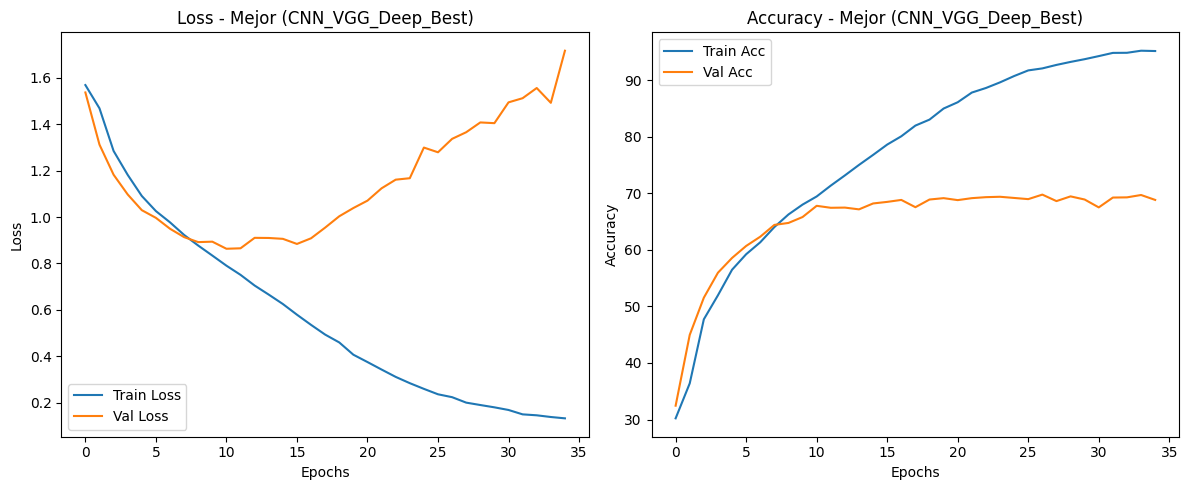

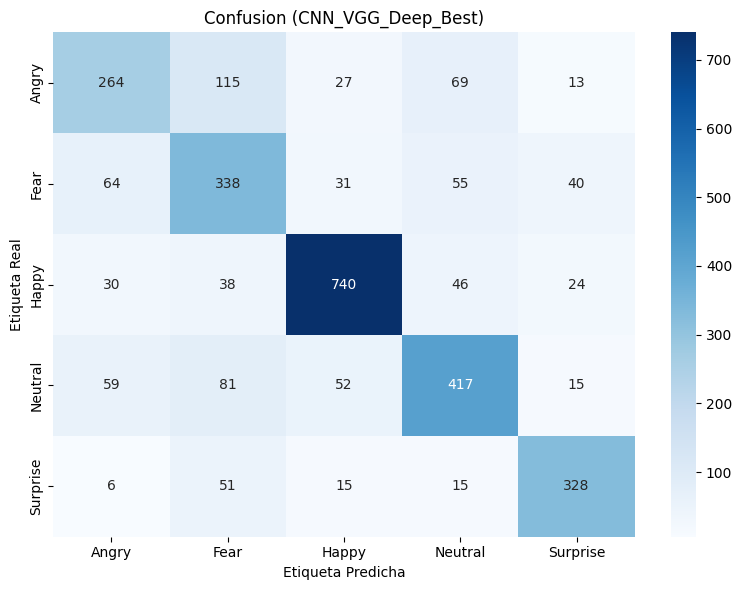

In [ ]:
import kagglehub

def main():
    """Función principal optimizada para maximizar Accuracy en FER-2013,
    con guardado completo en CSV y análisis desde histórico."""
    
    # --- Configuración global ---
    BATCH_SIZE = 64
    INPUT_CHANNELS = 1
    COLOR_MODE = 'grayscale' if INPUT_CHANNELS == 1 else 'rgb'

    # DEFINICIÓN DE EXPERIMENTOS (puedes añadir más sin tocar nada más)
    EXPERIMENTS = [
        {
            "name": "Experimento 1",
            "conv_layers": [
                (64, 3, 2),   
                (128, 3, 2), 
                (256, 3, 2),  
                (512, 3, 2)   
            ],
            "fc_layers": [512, 256], 
            "lr": 1e-4,      
            "dropout_conv": 0.3,
            "dropout_fc": 0.5, 
            "epochs": 40      
        },
        {
            "name": "Experimento 2",
            "conv_layers": [
                (32, 3, 1), 
                (64, 3, 1), 
                (128, 3, 1), 
                (256, 3, 1),
                (512, 3, 1)
            ],
            "fc_layers": [1024, 256], 
            "lr": 2e-4,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "epochs": 35
        },
        {
            "name": "Experimento 3",
            "conv_layers": [
                (64, 3, 1),
                (128, 3, 2),
                (256, 3, 2),
                (512, 3, 2)
            ],
            "fc_layers": [512, 256],
            "lr": 1e-4,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "batch_norm": True,
            "epochs": 50
        },
        {
            "name": "Experimento 4",
            "conv_layers": [
                (32, 3, 1),
                (64, 3, 1),
                (128, 3, 1),
                (256, 3, 1)
            ],
            "fc_layers": [256],
            "lr": 1e-3,
            "dropout_conv": 0.25,
            "dropout_fc": 0.4,
            "epochs": 40
        },
        {
            "name": "Experimento 5",
            "conv_layers": [
                (64, 3, 1),
                (128, 3, 2),
                (256, 3, 2),
                (512, 3, 2)
            ],
            "fc_layers": [512, 256],
            "lr": 1e-4,
            "dropout_conv": 0.2,
            "dropout_fc": 0.45,
            "epochs": 45
        },
        {
            "name": "Experimento 6",
            "conv_layers": [
                (64, 3, 2),
                (128, 3, 2),
                (256, 3, 4), 
                (512, 3, 4),  
            ],
            "fc_layers": [1024, 512],
            "lr": 5e-5,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "epochs": 50
        }

    ]

    # 1. SETUP & DATOS
    seed_everything(42)
    print("Descargando dataset (FER-2013)...")
    dataset_path = "C:\\Users\\laura\\Downloads\\datos"

    # Preparar datos
    train_loader, val_loader, test_loader, classes = prepare_dataloaders(
        dataset_path,
        batch_size=BATCH_SIZE,
        img_size=(48, 48),
        color_mode=COLOR_MODE
    )

    all_results = []
    input_shape = (48, 48, INPUT_CHANNELS)
    
    # 2. EJECUCIÓN DE EXPERIMENTOS
    for exp in EXPERIMENTS:
        print("\n====================================")
        print(f"Entrenando experimento: {exp['name']}")
        print("====================================\n")

        # A. CONSTRUIR
        model = ModularCNN(
            input_shape=input_shape,
            conv_layers=exp["conv_layers"],
            fc_layers=exp["fc_layers"],
            dropout_conv=exp.get("dropout_conv", 0.3),
            dropout_fc=exp.get("dropout_fc", 0.4),
            num_classes=len(classes)
        ).to(DEVICE)

        # B. ENTRENAR
        history = train_experiment(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=exp["epochs"],
            lr=exp["lr"],
            patience=8
        )

        # D. EVALUAR
        test_acc, test_loss, y_true, y_pred = evaluate_model(model, test_loader)
        print(f"[{exp['name']}] Test Accuracy = {test_acc:.4f}%")

        # E. ALMACENAR RESULTADOS (interno)
        result_entry = {
            "name": exp['name'],
            "conv_layers_config": str(exp["conv_layers"]),
            "fc_layers_config": str(exp["fc_layers"]),
            "learning_rate": exp["lr"],
            "dropout_conv": exp.get("dropout_conv", 0.3),
            "dropout_fc": exp.get("dropout_fc", 0.4),
            "epochs_run": len(history["train_loss"]),
            "test_loss": test_loss,
            "test_acc": test_acc,
            "history_dict": history,
            "y_true": y_true,
            "y_pred": y_pred
        }
        all_results.append(result_entry)

    # 3. GUARDAR EN CSV
    save_results(all_results)

    # 4. ANALIZAR HISTÓRICO COMPLETO DESDE EL CSV
    print("\n===============================")
    print("🔎 Analizando histórico completo desde CSV...")
    print("===============================\n")

    analyze_from_csv("resultados_cnn_fer2.csv", classes)


if __name__ == "__main__":
    main()


Iniciando análisis...
🏆 Mejor: Experimento 1 - 63.66675954%
📉 Peor: Experimento 5 - 59.62663695%


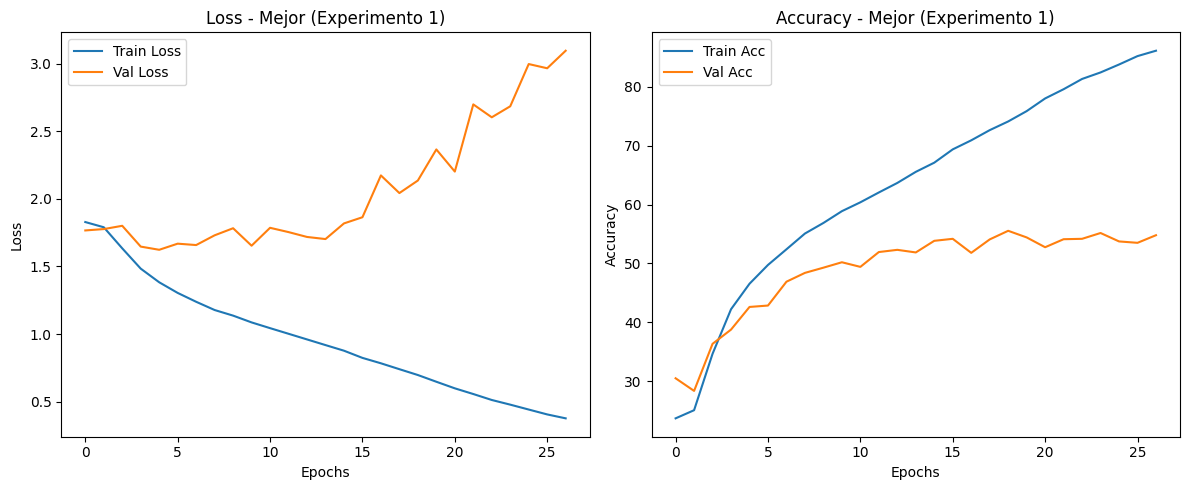

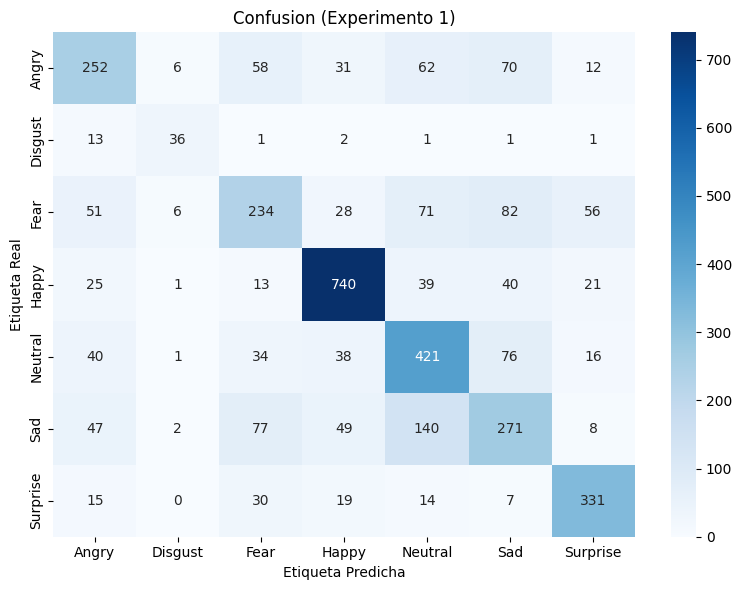

✅ Análisis completado.


In [43]:
dataset_path = kagglehub.dataset_download("pankaj4321/fer-2013-facial-expression-dataset")
BATCH_SIZE = 64
COLOR_MODE = "grayscale"

train_loader, val_loader, test_loader, classes = prepare_dataloaders(
        dataset_path,
        batch_size=BATCH_SIZE,
        img_size=(48, 48),
        color_mode=COLOR_MODE
    )    

try:
    print("Iniciando análisis...")
    analyze_from_csv("resultados_cnn_fer.csv", classes)
    print("✅ Análisis completado.")
except Exception as e:
    print(f"❌ Error durante el análisis: {e}")